In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#altri import futuri

## Caricamento e analisi del dataset

In [14]:
dataset = pd.read_csv("dataset/secondary_data.csv", sep=";")
print("Dimension:", dataset.shape)
dataset.head()

Dimension: (61069, 21)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

### Distribuzione delle features
Siamo interessati a classificare i funghi come velenosi o meno, per questo motivo identifichiamo le due classi di interesse a partire dalla colonna "class" del dataset.

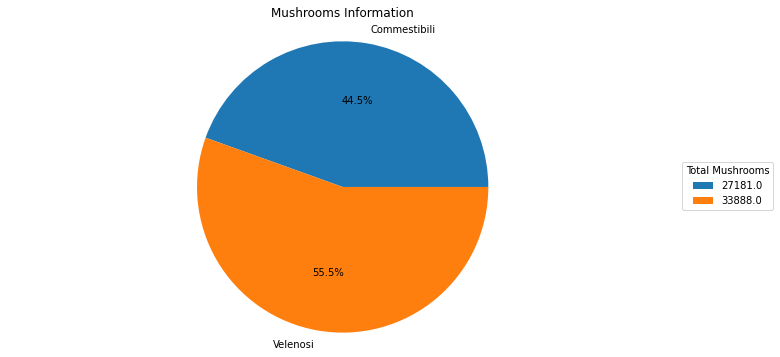

In [16]:
classes = [{"Commestibili": (dataset["class"] == "e").sum(), "Velenosi": (dataset["class"] == "p").sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Commestibili"])
total_p = float(total["Velenosi"])
mushrooms = [total_e, total_p]
mushrooms_labels = 'Commestibili','Velenosi'
fig, ax = plt.subplots(figsize = (12,6))
plt.pie(mushrooms,labels=mushrooms_labels,autopct='%1.1f%%')
plt.title('Mushrooms Information')
plt.axis('equal')
plt.legend(mushrooms,title="Total Mushrooms",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
fig.set_facecolor('white')
plt.show()

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

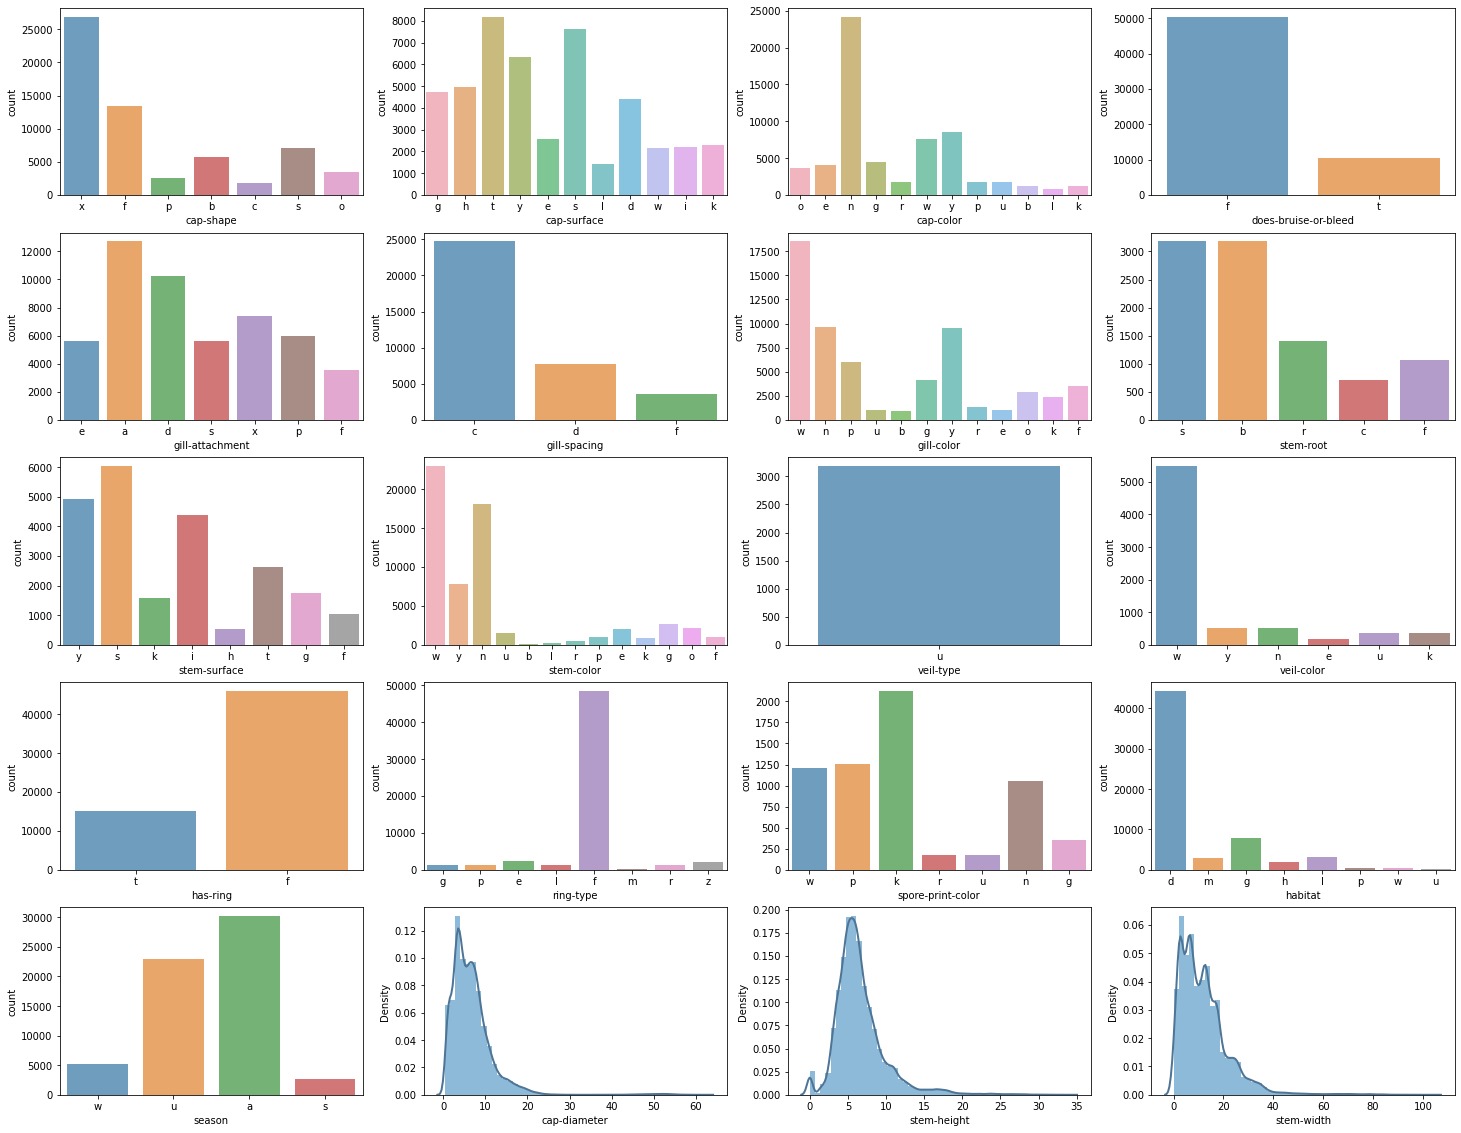

In [17]:
categorical = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 
'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
continous = ['cap-diameter', 'stem-height', 'stem-width']

fig = plt.figure(figsize=(25,20))
for i in range(0, len(categorical)) :
    fig.add_subplot(5,4,i+1)
    sns.countplot(x=categorical[i], data=dataset, alpha=.7)

for col in continous:
    fig.add_subplot(5,4,i+2)
    i+=1
    sns.distplot(dataset[col].dropna(), kde_kws={"lw": 2, "color": 'xkcd:cadet blue'}, hist_kws={"alpha": .5})

## Rimozione di features con dati nulli
Si rimuovono le features con varianza nulla presenti nel dataset, ovvero quelle features il cui valore è costante, nel nostro caso solamente la variabile "veil-type" come visibile graficamente.

In [18]:
dataset = dataset.drop("veil-type", 1)
dataset.isnull().sum()

/tmp/ipykernel_6741/3082125834.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset = dataset.drop("veil-type", 1)


class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64

Si cancellano le features che presentano valori nulli per più del 20%, utilizzando invece un meccanismo di imputazione per sopperire alla presenza di dati mancanti in quelle features da scartare ma che hanno buona correlazione (vd. dopo) con la variabile target e buona distribuzione dei valori.

In [19]:
dataset = dataset.drop("veil-color", 1)
dataset = dataset.drop("spore-print-color", 1)
dataset = dataset.drop("stem-root", 1)
dataset.head()

/tmp/ipykernel_6741/2386318944.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset = dataset.drop("veil-color", 1)
/tmp/ipykernel_6741/2386318944.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset = dataset.drop("spore-print-color", 1)
/tmp/ipykernel_6741/2386318944.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset = dataset.drop("stem-root", 1)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-surface,stem-color,has-ring,ring-type,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,17.09,y,w,t,g,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,18.19,y,w,t,g,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,17.74,y,w,t,g,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,15.98,y,w,t,p,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,17.20,y,w,t,p,d,w


Conversione delle features categoriche in nominali, si modifica prima il tipo di dato dei valori delle features da 'object' in 'category' per poi procedere con l'effettiva trasformazione dei valori categorici.

In [21]:
dataset = dataset.astype({"class": 'category', "cap-shape": 'category', "cap-surface": 'category', "cap-color": 'category', "does-bruise-or-bleed": 'category', 
"gill-attachment": 'category', "gill-spacing": 'category', "gill-color": 'category', "stem-surface": 'category', "stem-color": 'category',  "has-ring": 'category', 
"ring-type": 'category', "habitat": 'category', "season": 'category'}, errors = 'raise')
dataset.dtypes

class                   category
cap-diameter             float64
cap-shape               category
cap-surface             category
cap-color               category
does-bruise-or-bleed    category
gill-attachment         category
gill-spacing            category
gill-color              category
stem-height              float64
stem-width               float64
stem-surface            category
stem-color              category
has-ring                category
ring-type               category
habitat                 category
season                  category
dtype: object


Si trasformano i valori categorici in numerici (int64) e si salva il dizionario che mantiene il mapping per un eventuale utilizzo futuro.

In [22]:
mapping = []
encoder = LabelEncoder()
for i in range(len(dataset.columns)):
    value = dataset[dataset.columns[i]] 
    if (value.dtype == "category"):
        print(value)
        dataset[dataset.columns[i]] = encoder.fit_transform(value)
        mapping_dict = {index : label for index , label in enumerate(encoder.classes_)}
        mapping.append(mapping_dict)

mapping

0        p
1        p
2        p
3        p
4        p
        ..
61064    p
61065    p
61066    p
61067    p
61068    p
Name: class, Length: 61069, dtype: category
Categories (2, object): ['e', 'p']
0        x
1        x
2        x
3        f
4        x
        ..
61064    s
61065    f
61066    s
61067    f
61068    s
Name: cap-shape, Length: 61069, dtype: category
Categories (7, object): ['b', 'c', 'f', 'o', 'p', 's', 'x']
0        g
1        g
2        g
3        h
4        h
        ..
61064    s
61065    s
61066    s
61067    s
61068    s
Name: cap-surface, Length: 61069, dtype: category
Categories (11, object): ['d', 'e', 'g', 'h', ..., 's', 't', 'w', 'y']
0        o
1        o
2        o
3        e
4        o
        ..
61064    y
61065    y
61066    y
61067    y
61068    y
Name: cap-color, Length: 61069, dtype: category
Categories (12, object): ['b', 'e', 'g', 'k', ..., 'r', 'u', 'w', 'y']
0        f
1        f
2        f
3        f
4        f
        ..
61064    f
61065    f
6

[{0: 'e', 1: 'p'},
 {0: 'b', 1: 'c', 2: 'f', 3: 'o', 4: 'p', 5: 's', 6: 'x'},
 {0: 'd',
  1: 'e',
  2: 'g',
  3: 'h',
  4: 'i',
  5: 'k',
  6: 'l',
  7: 's',
  8: 't',
  9: 'w',
  10: 'y',
  11: nan},
 {0: 'b',
  1: 'e',
  2: 'g',
  3: 'k',
  4: 'l',
  5: 'n',
  6: 'o',
  7: 'p',
  8: 'r',
  9: 'u',
  10: 'w',
  11: 'y'},
 {0: 'f', 1: 't'},
 {0: 'a', 1: 'd', 2: 'e', 3: 'f', 4: 'p', 5: 's', 6: 'x', 7: nan},
 {0: 'c', 1: 'd', 2: 'f', 3: nan},
 {0: 'b',
  1: 'e',
  2: 'f',
  3: 'g',
  4: 'k',
  5: 'n',
  6: 'o',
  7: 'p',
  8: 'r',
  9: 'u',
  10: 'w',
  11: 'y'},
 {0: 'f', 1: 'g', 2: 'h', 3: 'i', 4: 'k', 5: 's', 6: 't', 7: 'y', 8: nan},
 {0: 'b',
  1: 'e',
  2: 'f',
  3: 'g',
  4: 'k',
  5: 'l',
  6: 'n',
  7: 'o',
  8: 'p',
  9: 'r',
  10: 'u',
  11: 'w',
  12: 'y'},
 {0: 'f', 1: 't'},
 {0: 'e', 1: 'f', 2: 'g', 3: 'l', 4: 'm', 5: 'p', 6: 'r', 7: 'z', 8: nan},
 {0: 'd', 1: 'g', 2: 'h', 3: 'l', 4: 'm', 5: 'p', 6: 'u', 7: 'w'},
 {0: 'a', 1: 's', 2: 'u', 3: 'w'}]

Dataset aggiornato a seguito della trasformazione dei valori categorici.

In [23]:
dataset

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-surface,stem-color,has-ring,ring-type,habitat,season
0,1,15.26,6,2,6,0,2,3,10,16.95,17.09,7,11,1,2,0,3
1,1,16.60,6,2,6,0,2,3,10,17.99,18.19,7,11,1,2,0,2
2,1,14.07,6,2,6,0,2,3,10,17.80,17.74,7,11,1,2,0,3
3,1,14.17,2,3,1,0,2,3,10,15.77,15.98,7,11,1,5,0,3
4,1,14.64,6,3,6,0,2,3,10,16.53,17.20,7,11,1,5,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,1,1.18,5,7,11,0,3,2,2,3.93,6.22,8,12,0,1,0,0
61065,1,1.27,2,7,11,0,3,2,2,3.18,5.43,8,12,0,1,0,0
61066,1,1.27,5,7,11,0,3,2,2,3.86,6.37,8,12,0,1,0,2
61067,1,1.24,2,7,11,0,3,2,2,3.56,5.44,8,12,0,1,0,2


In [24]:
dataset.isnull().sum()

class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-surface            0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

### Imputazione delle features con valori nulli
Si utilizza un meccanismo di imputazione per sopperire alla presenza di dati mancanti per le features da scartare per la politica scelta (nan > 20%), ma che presentano una buona correlazione con la variabile target e una buona distribuzione dei valori.
Ovviamente il meccanismo è applicato anche a quelle features con meno del 20% di valori nulli, così da ripristinare la variabile per l'uso nella classificazione rimpiazzando tutti i dati mancanti.

IMPUTAZIONE PER: cap-surface,14120 | gill-attachment,9884 | gill-spacing,25063 | stem-surface,38124 | ring-type,2471

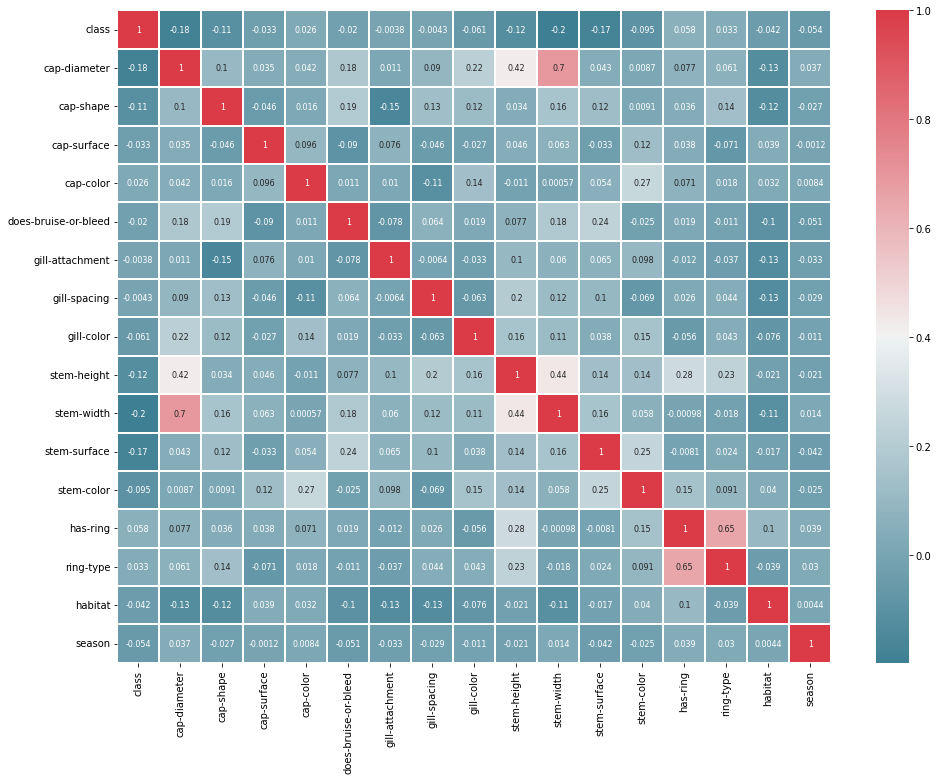

In [25]:
plt.figure(figsize=(16,12))

sns.heatmap(dataset.corr(), linewidths=.1, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, annot_kws={"size": 8})

plt.yticks(rotation=0);
#plt.savefig("corr.png", format='png', dpi=400, bbox_inches='tight')